In [ ]:
# ライブラリのインポート
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import missingno as msno
import pandas as pd
import seaborn as sns

# プロジェクトルートをパスに追加
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from src.data.loader import NHANESLoader
from src.data.preprocessor import NHANESPreprocessor
from src.data.validator import DataValidator

# 日本語フォント設定
plt.rcParams["font.sans-serif"] = ["Arial Unicode MS", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False

# 表示設定
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

# 図のスタイル
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# NHANES 2017-2018 データ探索

## 目的
- NHANESデータの基本統計量を把握
- 欠損値パターンを分析
- 重要変数の分布を確認
- 異常値の検出

## データ概要
- 参加者数: 9,254名
- データソース: NHANES 2017-2018
- 評価項目: 心血管、代謝、腎、肝、血液マーカー

## 1. データの読み込み

In [2]:
# データローダーの初期化
data_dir = project_root / "data" / "raw"
loader = NHANESLoader(data_dir)

# CSVファイルのリストを表示
csv_files = list(data_dir.glob("*.csv"))
print(f"Found {len(csv_files)} CSV files:")
for f in csv_files:
    print(f"  - {f.name}")

Found 1 CSV files:
  - nhanes_2017_2018_demo_lab_all.csv


In [3]:
# データの読み込み（最初のCSVファイルを読み込む）
if csv_files:
    df_raw = loader.load_csv(csv_files[0].name)
    print(f"\nLoaded data shape: {df_raw.shape}")
    print(f"Columns: {df_raw.columns.tolist()}")
else:
    print("No CSV files found. Please place data files in data/raw/")

2026-02-16 16:43:06.700 | INFO     | src.data.loader:load_csv:50 - Loading data from /Users/s2atoru/Python/COI-NEXT-Hackathon/data/raw/nhanes_2017_2018_demo_lab_all.csv
/Users/s2atoru/Python/COI-NEXT-Hackathon/src/data/loader.py:51: DtypeWarning: Columns (83,84,85) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath, **kwargs)
2026-02-16 16:43:07.114 | INFO     | src.data.loader:load_csv:52 - Loaded 9254 rows, 683 columns



Loaded data shape: (9254, 683)
Columns: ['SEQN', 'SDDSRVYR', 'RIDSTATR', 'RIAGENDR', 'RIDAGEYR', 'RIDAGEMN', 'RIDRETH1', 'RIDRETH3', 'RIDEXMON', 'RIDEXAGM', 'DMQMILIZ', 'DMQADFC', 'DMDBORN4', 'DMDCITZN', 'DMDYRSUS', 'DMDEDUC3', 'DMDEDUC2', 'DMDMARTL', 'RIDEXPRG', 'SIALANG', 'SIAPROXY', 'SIAINTRP', 'FIALANG', 'FIAPROXY', 'FIAINTRP', 'MIALANG', 'MIAPROXY', 'MIAINTRP', 'AIALANGA', 'DMDHHSIZ', 'DMDFMSIZ', 'DMDHHSZA', 'DMDHHSZB', 'DMDHHSZE', 'DMDHRGND', 'DMDHRAGZ', 'DMDHREDZ', 'DMDHRMAZ', 'DMDHSEDZ', 'WTINT2YR', 'WTMEC2YR', 'SDMVPSU', 'SDMVSTRA', 'INDHHIN2', 'INDFMIN2', 'INDFMPIR', 'URXVOL1', 'URDFLOW1', 'URDTIME1', 'URXVOL2', 'URDFLOW2', 'URDTIME2', 'URXVOL3', 'URDFLOW3', 'URDTIME3', 'PHQ020', 'PHACOFHR', 'PHACOFMN', 'PHQ030', 'PHAALCHR', 'PHAALCMN', 'PHQ040', 'PHAGUMHR', 'PHAGUMMN', 'PHQ050', 'PHAANTHR', 'PHAANTMN', 'PHQ060', 'PHASUPHR', 'PHASUPMN', 'PHAFSTHR', 'PHAFSTMN', 'PHDSESN', 'LBXGH', 'URXUMA', 'URXUMS', 'URDUMALC', 'URXUCR', 'URXCRS', 'URDUCRLC', 'URDACT', 'URXPREG', 'LBXHIVC', 

## 2. 基本統計量

In [4]:
# データ情報の取得
if "df_raw" in locals():
    info = loader.get_data_info(df_raw)

    print("=" * 60)
    print("DATA INFORMATION")
    print("=" * 60)
    print(f"Number of rows: {info['n_rows']:,}")
    print(f"Number of columns: {info['n_columns']}")
    print(f"Memory usage: {info['memory_usage_mb']:.2f} MB")
    print("\nData types:")
    print(pd.Series(info["dtypes"]).value_counts())

DATA INFORMATION
Number of rows: 9,254
Number of columns: 683
Memory usage: 155.35 MB

Data types:
float64    392
object     287
int64        4
Name: count, dtype: int64


In [5]:
# 基本統計量
if "df_raw" in locals():
    df_raw.describe()

## 3. 欠損値分析


MISSING DATA SUMMARY
          Missing_Count  Missing_Percentage
LBXHNAT            9252               99.98
LBXHIV1            9237               99.82
LBXHIV2            9237               99.82
URXVOL3            9221               99.64
URDTIME3           9221               99.64
...                 ...                 ...
FIAPROXY            474                5.12
FIAINTRP            474                5.12
INDFMIN2            474                5.12
DMDHRMAZ            191                2.06
DMDCITZN              3                0.03

[661 rows x 2 columns]


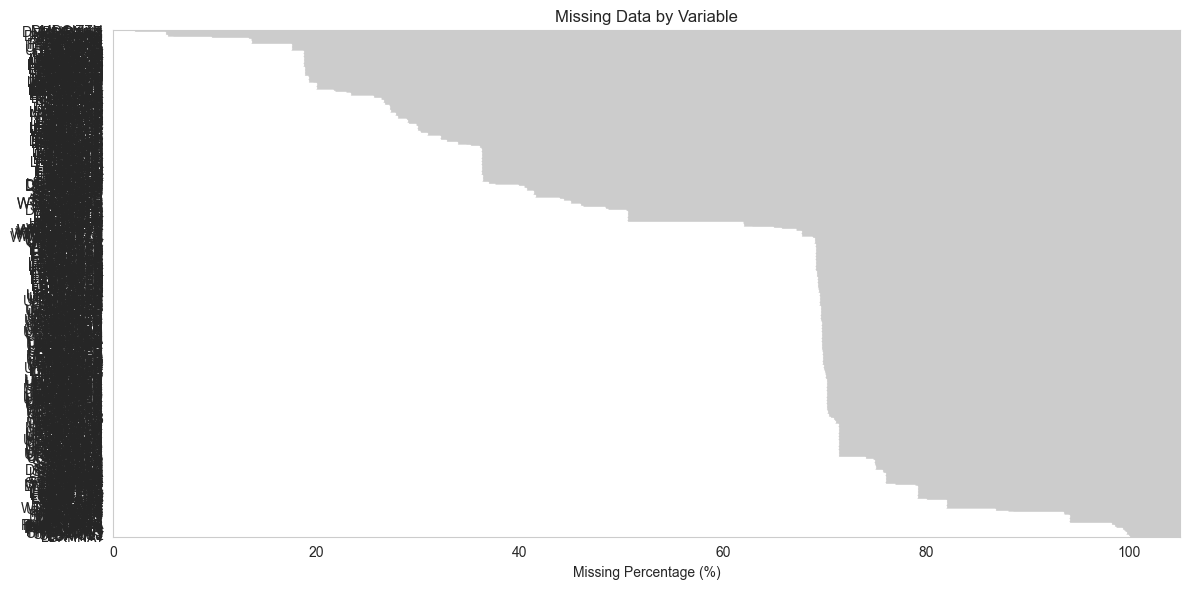

In [6]:
# 欠損値の割合
if "df_raw" in locals():
    missing_data = pd.DataFrame(
        {
            "Missing_Count": df_raw.isnull().sum(),
            "Missing_Percentage": (df_raw.isnull().sum() / len(df_raw) * 100).round(2),
        }
    )
    missing_data = missing_data[missing_data["Missing_Count"] > 0].sort_values(
        "Missing_Percentage", ascending=False
    )

    print("\n" + "=" * 60)
    print("MISSING DATA SUMMARY")
    print("=" * 60)
    print(missing_data)

    # 欠損値の可視化
    if len(missing_data) > 0:
        plt.figure(figsize=(12, 6))
        missing_data["Missing_Percentage"].plot(kind="barh", color="salmon")
        plt.xlabel("Missing Percentage (%)")
        plt.title("Missing Data by Variable")
        plt.tight_layout()
        plt.show()

/var/folders/3g/ss04h9ks5217bgkwgc1yf3d80000gn/T/ipykernel_80057/3246119528.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


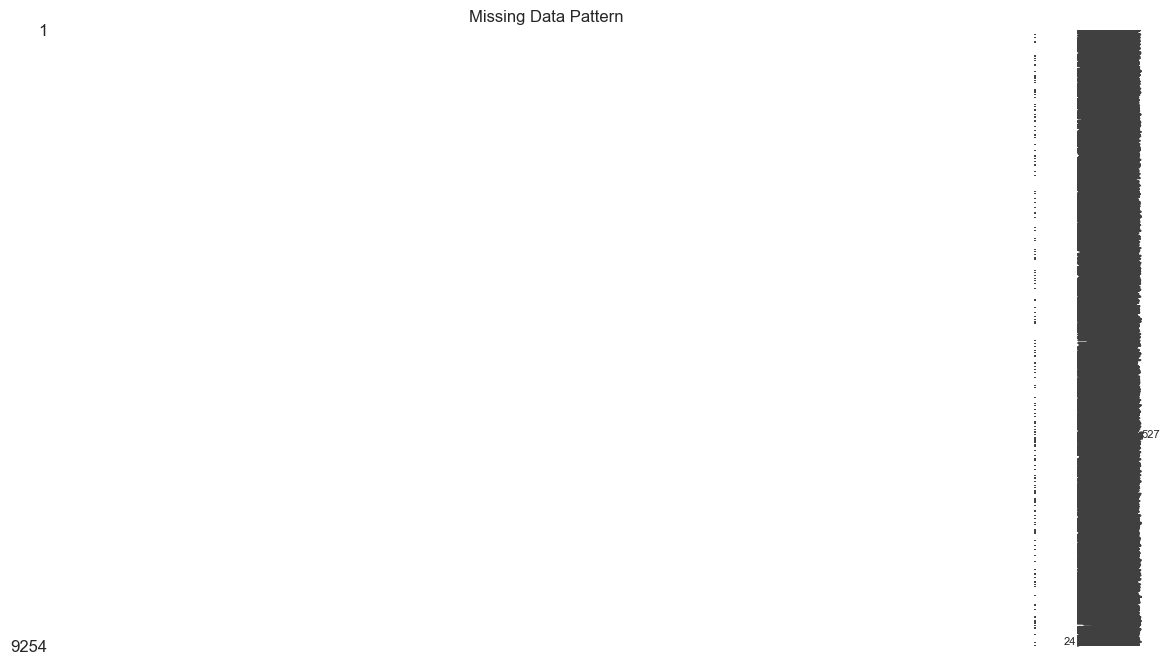

In [7]:
# missingnoによる欠損値パターンの可視化
if "df_raw" in locals():
    msno.matrix(df_raw, figsize=(14, 8), fontsize=10)
    plt.title("Missing Data Pattern")
    plt.tight_layout()
    plt.show()

## 4. データ前処理

In [8]:
# 前処理の実行
if "df_raw" in locals():
    preprocessor = NHANESPreprocessor()
    df_processed = preprocessor.preprocess(df_raw)

    print("\n" + "=" * 60)
    print("PREPROCESSING SUMMARY")
    print("=" * 60)
    summary = preprocessor.get_preprocessing_summary(df_raw, df_processed)
    print(f"Original shape: {summary['original_shape']}")
    print(f"Processed shape: {summary['processed_shape']}")
    print(f"\nNew columns added: {len(summary['new_columns'])}")
    for col in summary["new_columns"]:
        print(f"  - {col}")

2026-02-16 16:43:10.220 | INFO     | src.data.preprocessor:preprocess:47 - Starting preprocessing pipeline
2026-02-16 16:43:10.229 | INFO     | src.data.preprocessor:_handle_missing_values:82 - Handling missing values
2026-02-16 16:43:10.488 | WARNING  | src.data.preprocessor:_handle_missing_values:89 - Columns with >50% missing data:
RIDAGEMN    93.55
RIDEXAGM    62.90
DMQADFC     93.94
DMDYRSUS    78.95
DMDEDUC3    75.08
            ...  
URDP06LC    70.00
URXP10      70.01
URDP10LC    70.01
URXP25      70.02
URDP25LC    70.02
Length: 427, dtype: float64
2026-02-16 16:43:10.493 | INFO     | src.data.preprocessor:_convert_dtypes:107 - Converting data types
2026-02-16 16:43:11.061 | INFO     | src.data.preprocessor:_handle_outliers:141 - Handling outliers (winsorization at 99.5%)
2026-02-16 16:43:11.080 | DEBUG    | src.data.preprocessor:_handle_outliers:153 - RIDEXAGM: clipped 11 values at 238.00
2026-02-16 16:43:11.084 | DEBUG    | src.data.preprocessor:_handle_outliers:153 - WTINT2Y


PREPROCESSING SUMMARY
Original shape: (9254, 683)
Processed shape: (9254, 693)

New columns added: 10
  - age_group
  - gender_label
  - TC_HDL_ratio
  - LDL_HDL_ratio
  - non_HDL
  - eGFR
  - HOMA_IR
  - FIB4
  - AST_ALT_ratio
  - ACR


## 5. 人口統計的特徴

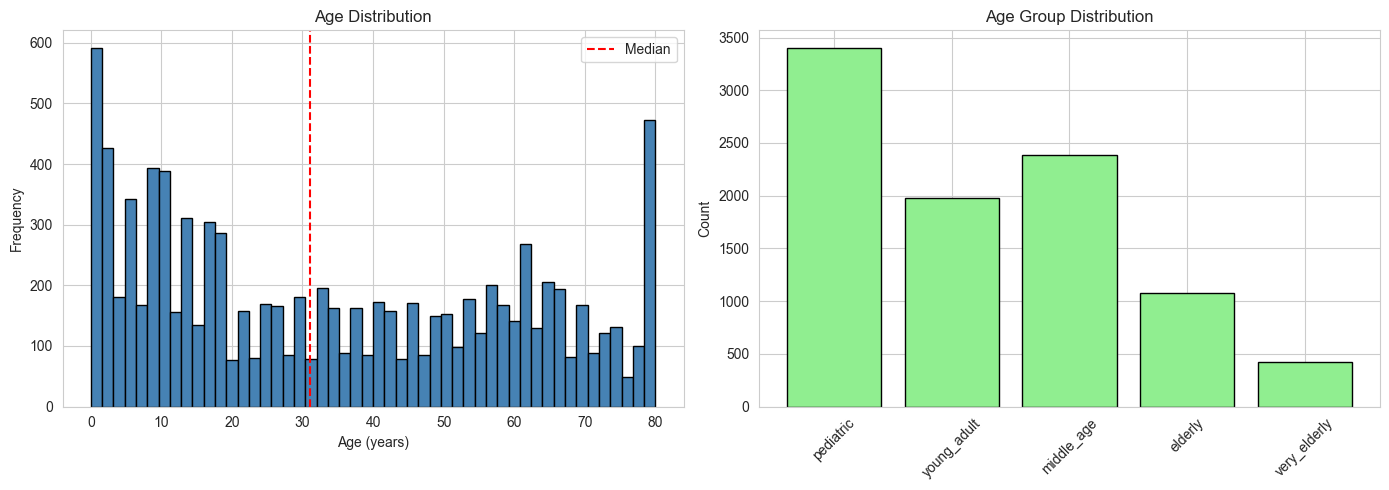


Age statistics:
count    9254.000000
mean       34.334234
std        25.500280
min         0.000000
25%        11.000000
50%        31.000000
75%        58.000000
max        80.000000
Name: RIDAGEYR, dtype: float64


In [ ]:
# 年齢分布
if "df_processed" in locals() and "RIDAGEYR" in df_processed.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # ヒストグラム
    axes[0].hist(
        df_processed["RIDAGEYR"].dropna(), bins=50, color="steelblue", edgecolor="black"
    )
    axes[0].set_xlabel("Age (years)")
    axes[0].set_ylabel("Frequency")
    axes[0].set_title("Age Distribution")
    axes[0].axvline(
        df_processed["RIDAGEYR"].median(), color="red", linestyle="--", label="Median"
    )
    axes[0].legend()

    # 年齢グループ
    if "age_group" in df_processed.columns:
        age_group_counts = df_processed["age_group"].value_counts().sort_index()
        axes[1].bar(
            range(len(age_group_counts)),
            age_group_counts.values,
            color="lightgreen",
            edgecolor="black",
        )
        axes[1].set_xticks(range(len(age_group_counts)))
        axes[1].set_xticklabels(age_group_counts.index, rotation=45)
        axes[1].set_ylabel("Count")
        axes[1].set_title("Age Group Distribution")

    plt.tight_layout()
    plt.show()

    print("\nAge statistics:")
    print(df_processed["RIDAGEYR"].describe())

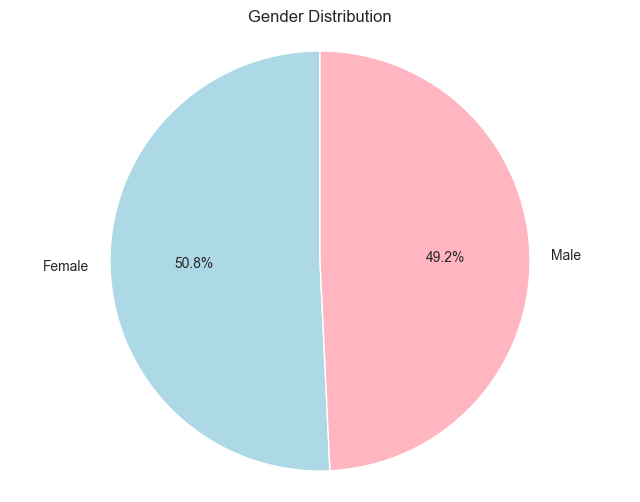


Gender counts:
gender_label
Female    4697
Male      4557
Name: count, dtype: int64


In [ ]:
# 性別分布
if "df_processed" in locals() and "gender_label" in df_processed.columns:
    gender_counts = df_processed["gender_label"].value_counts()

    plt.figure(figsize=(8, 6))
    plt.pie(
        gender_counts.values,
        labels=gender_counts.index,
        autopct="%1.1f%%",
        colors=["lightblue", "lightpink"],
        startangle=90,
    )
    plt.title("Gender Distribution")
    plt.axis("equal")
    plt.show()

    print("\nGender counts:")
    print(gender_counts)

## 6. 重要変数の分布

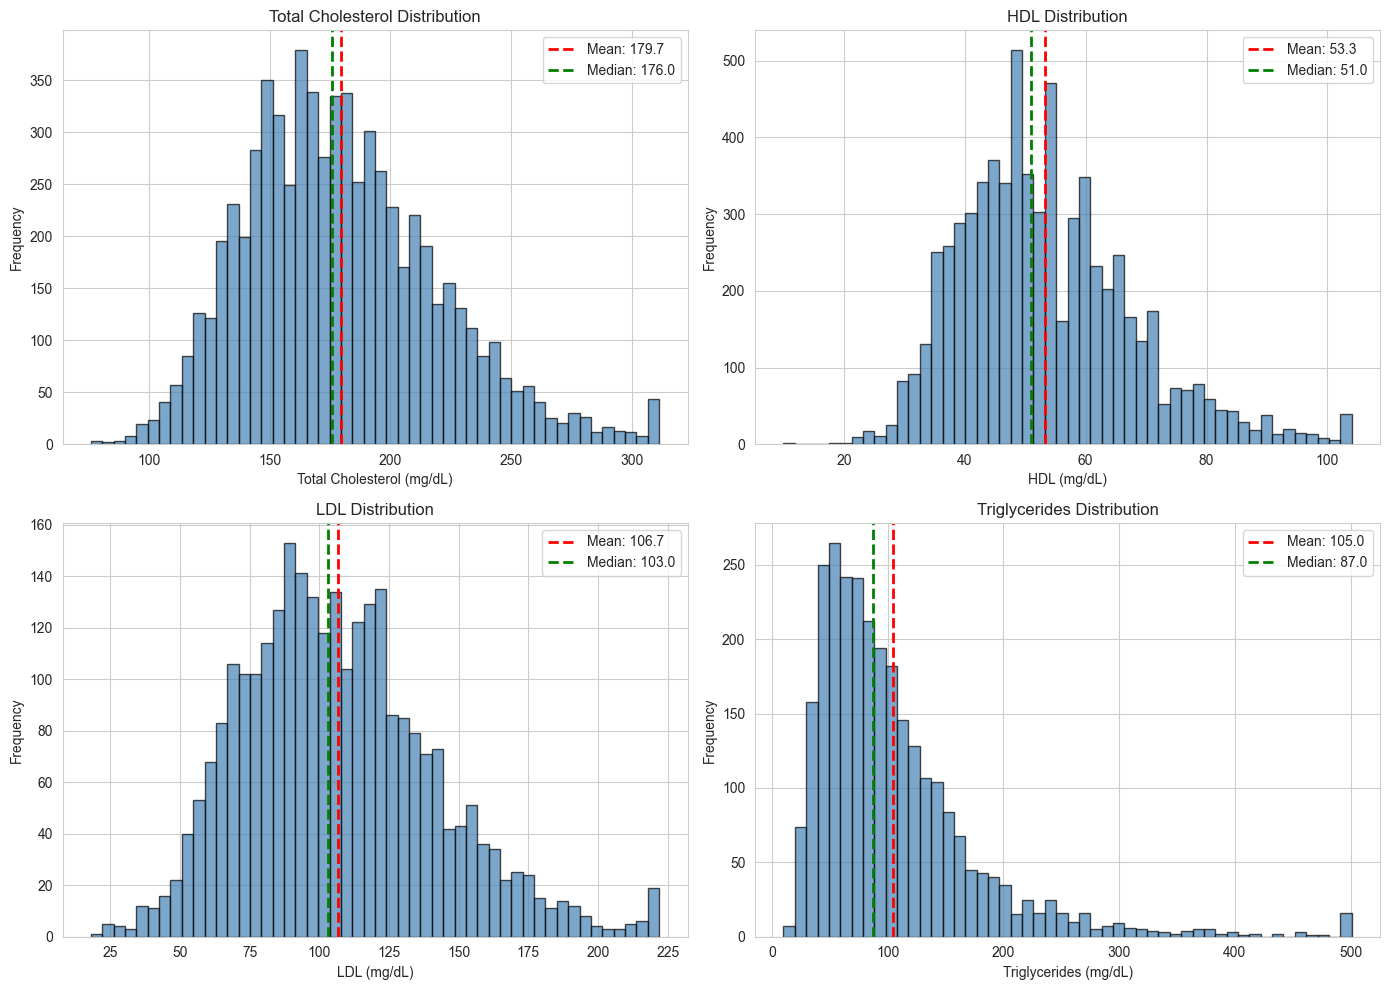

In [11]:
# 脂質プロファイル
if "df_processed" in locals():
    lipid_vars = ["LBXTC", "LBDHDD", "LBDLDL", "LBXTR"]
    lipid_labels = ["Total Cholesterol", "HDL", "LDL", "Triglycerides"]

    existing_lipid_vars = [v for v in lipid_vars if v in df_processed.columns]

    if existing_lipid_vars:
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        axes = axes.ravel()

        for i, (var, label) in enumerate(
            zip(existing_lipid_vars, lipid_labels[: len(existing_lipid_vars)])
        ):
            data = df_processed[var].dropna()
            axes[i].hist(data, bins=50, color="steelblue", alpha=0.7, edgecolor="black")
            axes[i].axvline(
                data.mean(),
                color="red",
                linestyle="--",
                linewidth=2,
                label=f"Mean: {data.mean():.1f}",
            )
            axes[i].axvline(
                data.median(),
                color="green",
                linestyle="--",
                linewidth=2,
                label=f"Median: {data.median():.1f}",
            )
            axes[i].set_xlabel(f"{label} (mg/dL)")
            axes[i].set_ylabel("Frequency")
            axes[i].set_title(f"{label} Distribution")
            axes[i].legend()

        plt.tight_layout()
        plt.show()

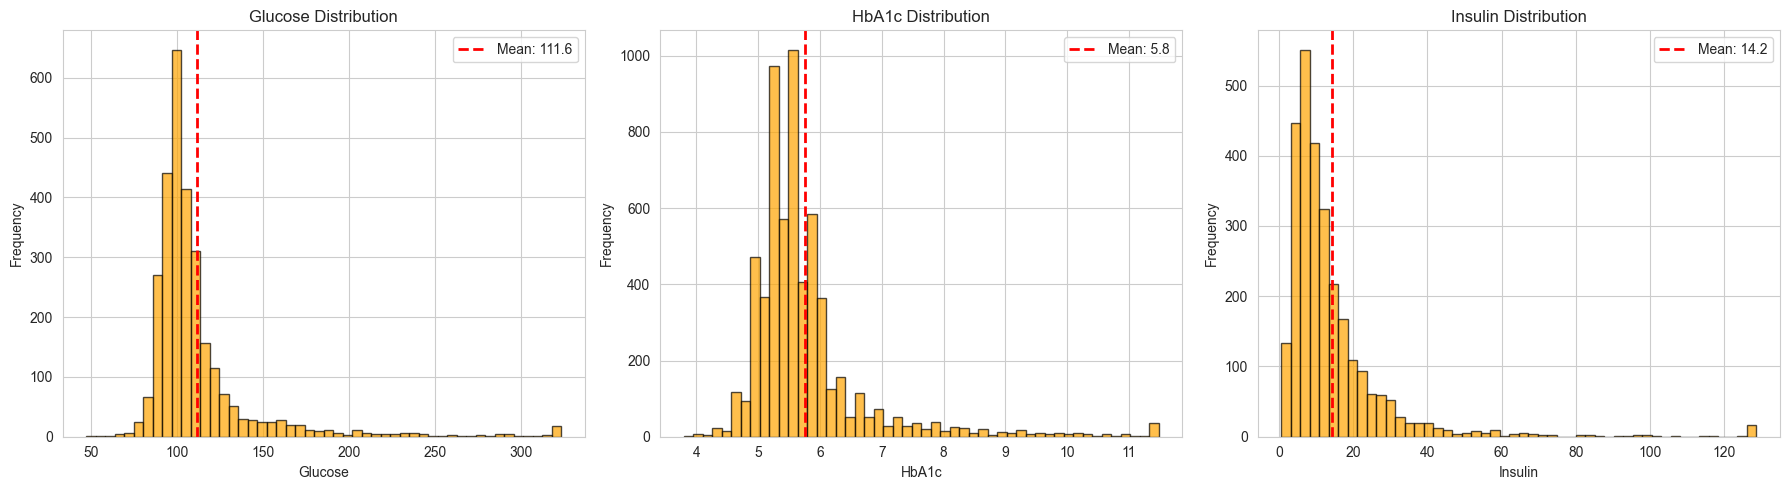

In [12]:
# 代謝マーカー
if "df_processed" in locals():
    metabolic_vars = ["LBXGLU", "LBXGH", "LBXIN"]
    metabolic_labels = ["Glucose", "HbA1c", "Insulin"]

    existing_metabolic_vars = [v for v in metabolic_vars if v in df_processed.columns]

    if existing_metabolic_vars:
        n_vars = len(existing_metabolic_vars)
        fig, axes = plt.subplots(1, n_vars, figsize=(6 * n_vars, 5))
        if n_vars == 1:
            axes = [axes]

        for i, (var, label) in enumerate(
            zip(existing_metabolic_vars, metabolic_labels[:n_vars])
        ):
            data = df_processed[var].dropna()
            axes[i].hist(data, bins=50, color="orange", alpha=0.7, edgecolor="black")
            axes[i].axvline(
                data.mean(),
                color="red",
                linestyle="--",
                linewidth=2,
                label=f"Mean: {data.mean():.1f}",
            )
            axes[i].set_xlabel(label)
            axes[i].set_ylabel("Frequency")
            axes[i].set_title(f"{label} Distribution")
            axes[i].legend()

        plt.tight_layout()
        plt.show()

## 7. 変数間相関分析

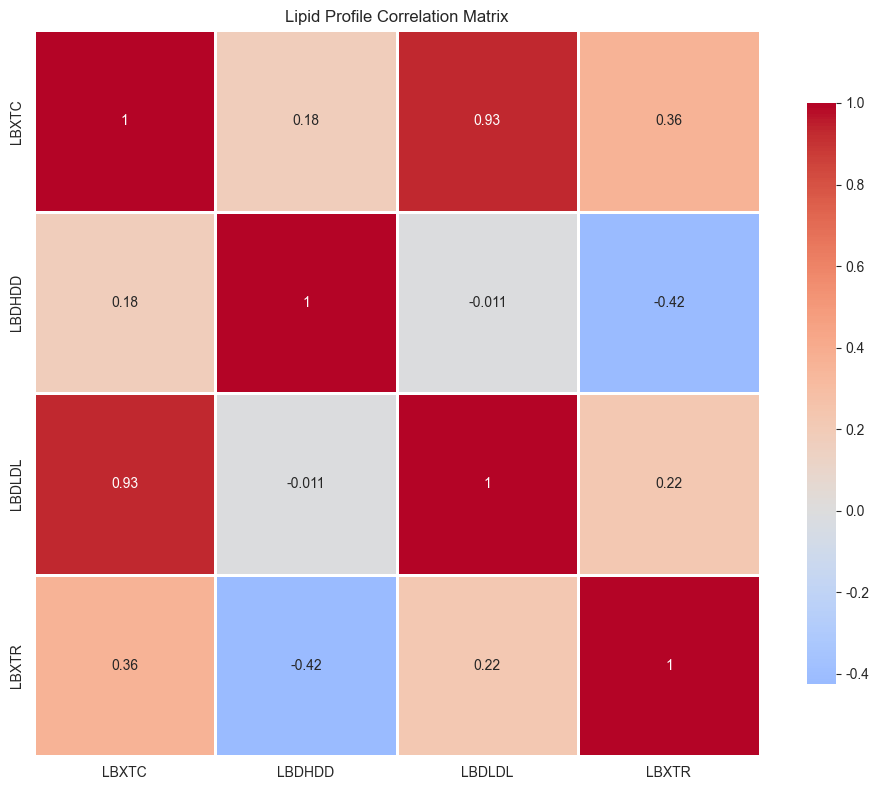

In [13]:
# 脂質マーカー間の相関
if "df_processed" in locals():
    lipid_vars = ["LBXTC", "LBDHDD", "LBDLDL", "LBXTR"]
    existing_lipid_vars = [v for v in lipid_vars if v in df_processed.columns]

    if len(existing_lipid_vars) > 1:
        correlation_matrix = df_processed[existing_lipid_vars].corr()

        plt.figure(figsize=(10, 8))
        sns.heatmap(
            correlation_matrix,
            annot=True,
            cmap="coolwarm",
            center=0,
            square=True,
            linewidths=1,
            cbar_kws={"shrink": 0.8},
        )
        plt.title("Lipid Profile Correlation Matrix")
        plt.tight_layout()
        plt.show()

## 8. データ検証

In [14]:
# データ品質検証
if "df_processed" in locals():
    validator = DataValidator()
    validation_results = validator.validate(df_processed)

    print(validator.generate_report())

2026-02-16 16:43:13.115 | INFO     | src.data.validator:validate:35 - Starting data validation
2026-02-16 16:43:13.122 | WARNING  | src.data.validator:validate:54 - Validation check failed: consistency
2026-02-16 16:43:13.122 | ERROR    | src.data.validator:validate:59 - Some validation checks failed


DATA VALIDATION REPORT
Overall Status: FAILED

✓ DUPLICATES: No duplicates
✓ MISSING_CRITICAL: All critical columns present with acceptable missing rates
✓ VALUE_RANGES: All values within expected ranges
✗ CONSISTENCY: 1 consistency issues found
  - issues: [{'type': 'lipid_profile_inconsistency', 'n_cases': 1, 'description': 'TC ≠ HDL + LDL + TG/5 (>20% difference)'}]


## 9. データ保存

In [15]:
# 前処理済みデータの保存
if "df_processed" in locals():
    processed_dir = project_root / "data" / "processed"
    processed_dir.mkdir(exist_ok=True)

    output_path = processed_dir / "nhanes_processed.csv"
    df_processed.to_csv(output_path, index=False)
    print(f"\nProcessed data saved to: {output_path}")
    print(f"Shape: {df_processed.shape}")


Processed data saved to: /Users/s2atoru/Python/COI-NEXT-Hackathon/data/processed/nhanes_processed.csv
Shape: (9254, 693)


## まとめ

このノートブックでは:
1. NHANESデータの読み込みと基本統計量の確認
2. 欠損値パターンの分析
3. データの前処理（欠損値処理、外れ値処理、派生変数生成）
4. 人口統計的特徴の可視化
5. 重要変数の分布確認
6. 変数間相関の分析
7. データ品質の検証
8. 前処理済みデータの保存

を実行しました。

次のステップ:
- 02_feature_engineering.ipynb: 追加の特徴量エンジニアリング
- 03_risk_model_development.ipynb: リスクスコアモデルの開発とテスト